In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
from matplotlib.colors import LinearSegmentedColormap
import pickle
import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import seaborn as sns
import cartopy
import numpy.ma as ma
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

# import snow depth and CS2_CPOM radar freeboard data from 01/01/2010 - 31/12/2020
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])
all_fbs = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])

### calculate slope for every grid cell

In [3]:
# do smooth anoms for each grid cell

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # each day, make the 31 day running mean (15 either side)
    
    snows_31day = np.nanmean(snow[day-T1:day+T1],axis=0) # 31-day running mean for each grid cell in time dimension
    freeb_31day = np.nanmean(all_fbs[day-T1:day+T1],axis=0)
    
    # now make anomalies from 31 day means
    
    snows_anoms_big[day] = snow[day] - snows_31day 
    freeb_anoms_big[day] = all_fbs[day] - freeb_31day
    

# the following for loop can actually be removed by taking the running mean with convolve
# RDCM has done this before, you have to convolve along an axis of a 3d numpy array using a special module

fb_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)
# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
    
        fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
        sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 4018/4018 [00:28<00:00, 142.04it/s]


In [4]:
ps_map = np.full((snow.shape[1],snow.shape[2]), np.nan)
rs_map = np.full((snow.shape[1],snow.shape[2]), np.nan)
ss_map = np.full((snow.shape[1],snow.shape[2]), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(snow.shape[1]),
                              np.arange(snow.shape[2]))):
    # calculate p and r for full timeseries per grid cell
    
    mask = ~np.isnan(sd_running_mean_anoms[:,i,j]) & ~np.isnan(fb_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue
        
            
        rstats = linregress(sd_running_mean_anoms[:,i,j][mask],fb_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
        r = rstats.rvalue
        p = rstats.pvalue
        s = rstats.slope
        ps_map[i,j] = p
        rs_map[i,j] = r
        ss_map[i,j] = s

129600it [00:12, 10367.33it/s]


### calculate some stats to put in paper

In [5]:
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')

# regions = Barents,Kara,Laptev, E. Siberian, Chukchi, Beaufort
regs = [8,9,10,11,12,13]

slopes = ss_map.copy()
slopes[~np.isin(mask_values, regs)] = np.nan # NaN other regions
slopes[ps_map>0.05] = np.nan # remove statistically insignificant results

print('pos vs neg stat sig grid cells in marginal seas:')
pos = np.where(slopes>0)[0]
print('number of pos: ',len(pos))

neg = np.where(slopes<0)[0]
print('number of neg: ',len(neg))
ratio = len(pos)/(len(pos)+len(neg))
print('ratio: ' ,ratio)

print('averages of stat sig grid cells in marginal seas:')
pos = slopes.copy()
pos[pos<0] = np.nan
pos[pos==0] = np.nan
pos_mean=np.nanmean(pos)
print('mean of pos :', pos_mean)
neg = slopes.copy()
neg[neg>0] = np.nan
neg[neg==0] = np.nan
neg_mean=np.nanmean(neg)
print('mean of neg :', neg_mean)

# Central Arctic only
slopes = ss_map.copy()
slopes[~np.isin(mask_values, 15)] = np.nan # NaN other regions
slopes[ps_map>0.05] = np.nan # remove statistically insignificant results

print('pos vs neg stat sig grid cells in Central Arctic:')
pos = np.where(slopes>0)[0]
print('number of pos: ',len(pos))

neg = np.where(slopes<0)[0]
print('number of neg: ',len(neg))
ratio = len(pos)/(len(pos)+len(neg))
print('ratio: ' ,ratio)

print('averages of stat sig grid cells in Central Arctic:')
pos = slopes.copy()
pos[pos<0] = np.nan
pos[pos==0] = np.nan
pos_mean=np.nanmean(pos)
print('mean of pos :', pos_mean)
neg = slopes.copy()
neg[neg>0] = np.nan
neg[neg==0] = np.nan
neg_mean=np.nanmean(neg)
print('mean of neg :', neg_mean)

pos vs neg stat sig grid cells in marginal seas:
number of pos:  3497
number of neg:  1766
ratio:  0.664449933498005
averages of stat sig grid cells in marginal seas:
mean of pos : 0.22380540138094868
mean of neg : -0.32563326840227785
pos vs neg stat sig grid cells in Central Arctic:
number of pos:  1405
number of neg:  1291
ratio:  0.5211424332344213
averages of stat sig grid cells in Central Arctic:
mean of pos : 0.07890549656916317
mean of neg : -0.08186683803554791


### calculate seasonal, regional slopes

In [6]:
# select winter season days 
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017',
           '2017-2018','2018-2019','2019-2020']
#seasons: 01/10 - 30/04
dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2465,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3195,3407), # 2018-2019
        np.arange(3560,3773), # 2019-2020
       ]

In [7]:
# function to calculate regional means 
def regions_WG(regs):
    WG_mean = []
    WG_c = all_interps.copy()
    for day in days:
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in days:
        WG_mean.append(np.nanmean(WG_c[day]))
    return(WG_mean)

# function to calculate running mean, where T = np.int(number of days/2)
def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T]))

    for i in range(np.size(means)-T,np.size(means)):
        r.append(np.nanmean(means[i-T:]))

    return r

In [8]:
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

T = 15 #31-day running mean

### calculate regional smoothed anomalies ###
all_interps = snow
SM_anoms = {}
for region, reg in zip(regions, regs):
    dm = regions_WG(reg)
    rm = runningmean(dm,T=15)
    SM_anoms[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))
    
all_interps = all_fbs
fb_anoms = {}
for region, reg in zip(regions, regs):
    dm = regions_WG(reg)
    rm = runningmean(dm,T=15)
    fb_anoms[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))

In [9]:
### calculate regional correlations ####

def stats():
    fb = fb_anoms[region][day]
    snow = SM_anoms[region][day]
    mask = ~np.isnan(fb) & ~np.isnan(snow) 
    try:
        rstats = linregress(snow[mask],fb[mask])
        s = rstats.slope
        p = rstats.pvalue
        return(p,s)
    except:
        s = np.nan
        p = np.nan

ps_table = np.full((len(seasons),len(regions)),np.nan)
ss_table = np.full((len(seasons),len(regions)),np.nan)

for counter, region in enumerate(regions):
    for count, season in enumerate(seasons):
        day = dayss[count]
        p,s = stats()
        ss_table[count,counter] = s
        ps_table[count,counter] = p
        
df = pd.DataFrame(data=ss_table, index=None, columns=None)

### plot figure

In [10]:
### create MYI area line
all_MYI = []
datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/CDS_icetype/'

all_MYI = np.full((len(days),432, 432),np.nan)

for day in tqdm.tqdm(days):#key is a date, so looping through each day for which we have gridded CS2 obs in this season
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_ease2-250_cdr-v2p0_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0 
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
total = len(dayss[0])+len(dayss[1])+len(dayss[2])+len(dayss[3])+len(dayss[4])+len(dayss[5])+len(dayss[6])+len(dayss[7])+len(dayss[8])+len(dayss[9])
day_ave = MYI_days/total
day_ave[icetype_lat>89]=0.6 # remove polehole

100%|██████████████████████████████████████| 4018/4018 [00:16<00:00, 249.27it/s]


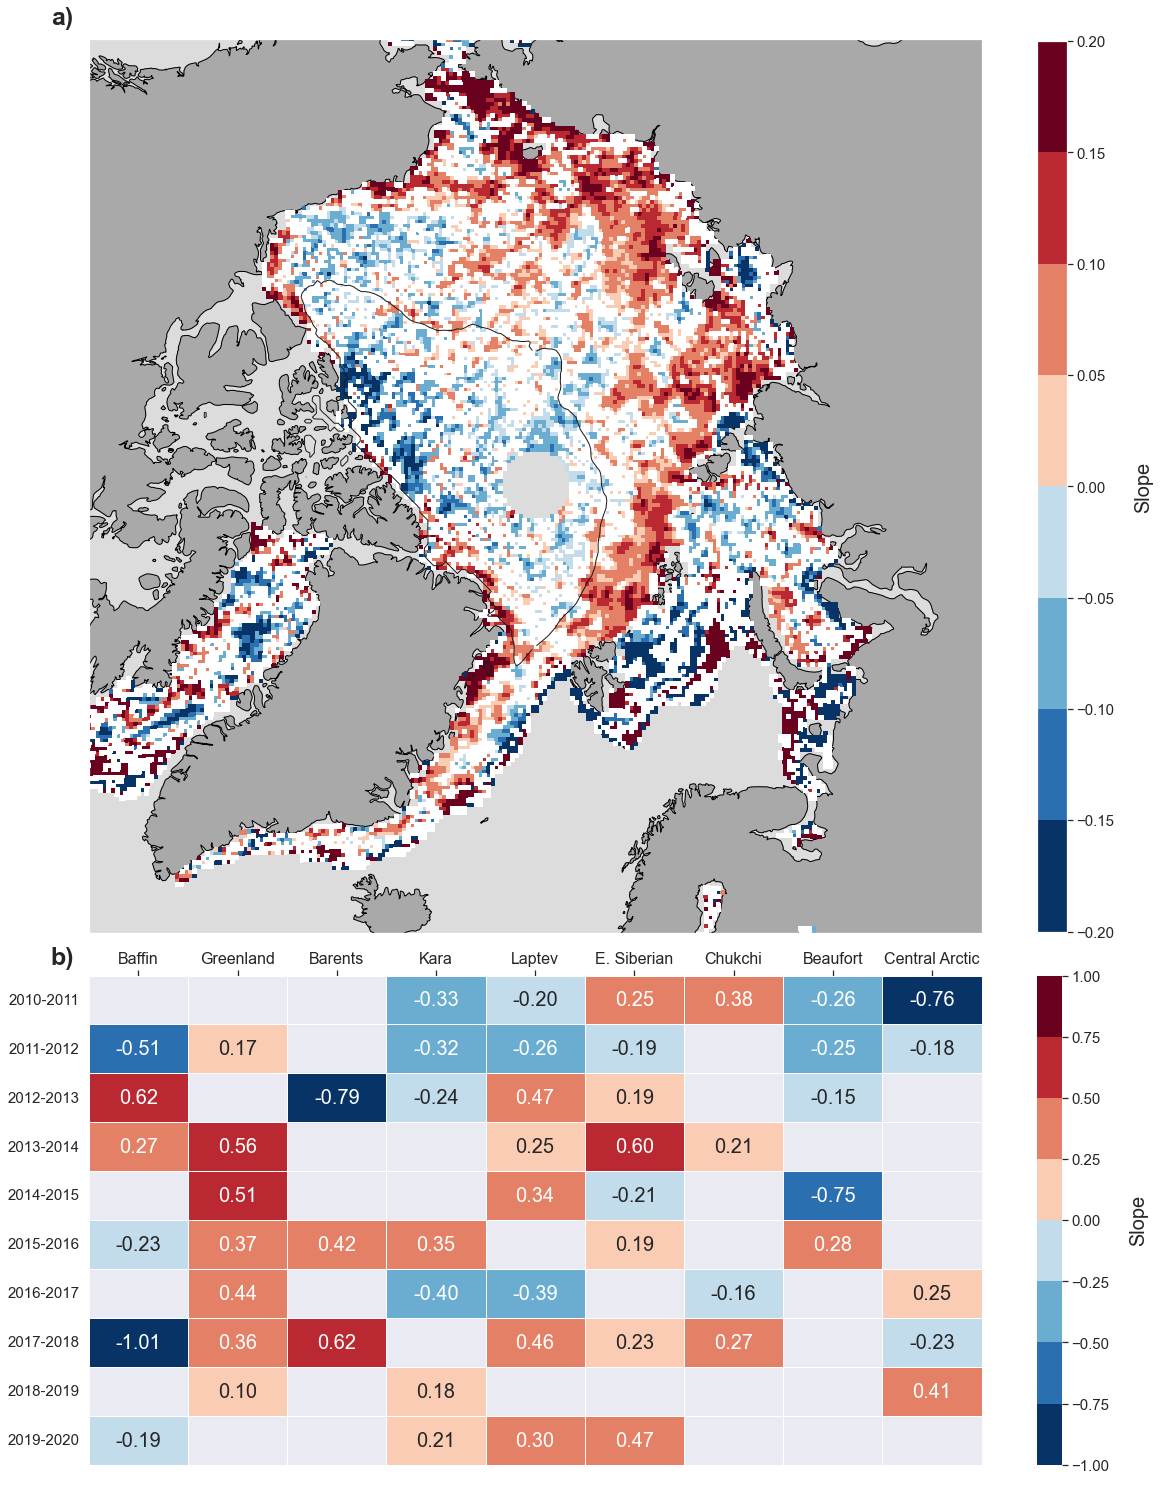

In [12]:
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')
list_colors = ['#073366','#2A70B1','#6BACD1','#C2DCEC','#FBCCB4','#E48066','#BA2832','#6A011F']  

ss_map[ps_map>0.05] = 1000
grey = ss_map.copy()
grey[grey <1000] = np.nan
ss_map[rs_map==1000] = np.nan

fig = plt.figure(figsize=(20,27))
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[2, 1],hspace=0)

ax1 = fig.add_subplot(spec[0],projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
cm = LinearSegmentedColormap.from_list('map', list_colors, N = 8)
p_map = ax1.pcolormesh(lons,lats,ss_map,cmap=cm,vmin=-0.2,vmax=0.2, transform=ccrs.PlateCarree())
ax1.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000, transform=ccrs.PlateCarree())
ax1.set_title('a)', x = -0.03,y = 1.01,fontweight="bold",fontsize=25)
a = fig.colorbar(p_map,shrink=0.91,aspect=30)
a.ax.tick_params(labelsize=15)
a.set_label("Slope",fontsize=20,labelpad=20)

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

cont_less = ax1.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

cont_Great = ax1.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1.0)

mask = ps_table.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax2 = fig.add_subplot(spec[1])
ax2 = sns.heatmap(df, mask = mask, cmap=cm, annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons)
sns.set(rc = {'figure.figsize':(20,27)})
ax2.xaxis.tick_top()
ax2.set_xlabel(' ')    
ax2.set_yticklabels(seasons,rotation = 0,fontsize=15)
ax2.set_xticklabels(regions,fontsize=16)
cbar = ax2.collections[0].colorbar
cbar.set_label("Slope",fontsize = 20,labelpad=20)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('b)', x = -0.03,y = 1.01,fontsize = 25, fontweight="bold")

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/CS2_SM_slope.png',bbox_inches = "tight")